# Introduction

This group work project 1 (GWP 1) will mainly focus on pricing options by making use of volatility models. We will explore how to calibrate different models to observed market data. Furthermore, we will check the accuracy of the prices using the put-call parity relationship to ensure abritrage free markets.

# Step 1:Calibrating the Heston Model 1993 without jumps (Team member A)

1a) Using the Lewis (2001) Approach
- This approach falls under fourier based option pricing which can be denoted using the formula below

$$
\begin{equation*}
    C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_{0}^{\infty} \mathbf{Re}[e^{izk} \varphi(z-i/2)] \frac{dz}{z^2+1/4}
\end{equation*}
$$

- Hence, we also need to define the characteristic function under the Heston 1993 model

$$
\
\begin{equation*}
  \varphi^{H93} (u, T) = e^{H_1(u, T)+H_2(u,T)\nu_0}
\end{equation*}
$$
\
where

$$
\
\begin{equation*}
  H_1 (u, T) \equiv r_0 uiT + \frac{c_1}{\sigma_\nu^2}\Biggl\{ (\kappa_\nu - \rho \sigma_\nu ui+c_2) T - 2 log \left[ \frac{1-c_3e^{c_2T}}{1-c_3} \right] \Biggl\}
\end{equation*}
$$
$$
\
\begin{equation*}
  H_2 (u, T) \equiv \frac{\kappa_\nu - \rho \sigma_\nu ui + c_2}{\sigma_\nu^2} \left[ \frac{1-e^{c_2T}}{1-c_3e^{c_2T}} \right]
\end{equation*}
$$
$$
\
\begin{equation*}
  c_1 \equiv \kappa_\nu \theta_\nu
\end{equation*}
$$
$$
\
\begin{equation*}
  c_2 \equiv - \sqrt{(\rho \sigma_\nu ui - \kappa_\nu)^2 - \sigma_\nu^2(-ui-u^2) }
\end{equation*}
$$
$$
\
\begin{equation*}
  c_3 \equiv \frac{\kappa_\nu - \rho \sigma_\nu ui + c_2}{\kappa_\nu - \rho \sigma_\nu ui - c_2}
\end{equation*}
$$


-Furthermore there is need to define the intergral value in Lewis 2001, which is depicted with the formula below:


$$
\
\begin{equation*}
    C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_{0}^{\infty} \mathbf{Re}[e^{izk} \varphi(z-i/2)] \frac{dz}{z^2+1/4}
\end{equation*}
$$




In [1]:
#Importing the neccessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.stats import norm
from scipy.optimize import brute, fmin
import random
from scipy.optimize import brute, fmin
import numpy as np
from scipy.fft import fft, ifft

plt.rcParams['figure.figsize'] = (8, 6)

In [2]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of Asian call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function."""

    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

The calibration process

Calibration will be done based market data for the SM stock given the following parameters:



$$
S_0 = 232.90;\quad r = 1.50\%;\quad T = 15 \text{ days}
$$

In [3]:
options.head()

NameError: name 'options' is not defined

In [5]:
#importing market data

options = pd.read_excel("MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx" )

S0 = 232.9
options['Current_Price'] = S0
#averaging_prices = options[['Current_Price', "Call"]].values
options = options[(options["Days to maturity"]==15) & (options["Type"]=='C')]
for row, option in options.iterrows():
    T = (option["Days to maturity"]) / 250.0
    options.loc[row, "T"] = T
    options.loc[row, "r"] = 1.5/100

options.head(10)

,Days to maturity,Strike,Price,Type,Current_Price,T,r
0,15,227.5,10.52,C,232.9,0.06,0.015
1,15,230.0,10.05,C,232.9,0.06,0.015
2,15,232.5,7.75,C,232.9,0.06,0.015
3,15,235.0,6.01,C,232.9,0.06,0.015
4,15,237.5,4.75,C,232.9,0.06,0.015


The next step is to make sure that we carry out modifying techniques to ensure we match market data. Thus making use of fuctions i.e, mean squared error (MSE) function.

In [20]:
i = 0
min_MSE = 500

def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        se.append((model_value - option["Price"]) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

In [21]:
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
                (2.5, 10.6, 5.0),  # kappa_v
                (0.01, 0.041, 0.01),  # theta_v
                (0.05, 0.251, 0.1),  # sigma_v
                (-0.75, 0.01, 0.25),  # rho
                (0.01, 0.031, 0.01),
            ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=950, maxfun=900
    )
    return opt

In [22]:
kappa_v, theta_v, sigma_v, rho, v0 = H93_calibration_full()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  23.560 |  23.560
  25 | [ 2.5   0.02  0.05 -0.75  0.02] |  16.264 |  11.964
  50 | [ 2.5   0.02  0.25 -0.75  0.03] |  11.689 |  11.662
  75 | [ 2.5   0.03  0.15 -0.5   0.01] |  22.320 |  11.367
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |  15.462 |  11.089
 125 | [ 2.5   0.04  0.25 -0.5   0.03] |  11.135 |  11.079
 150 | [ 7.5   0.01  0.15 -0.25  0.01] |  23.608 |  11.079
 175 | [ 7.5   0.02  0.05 -0.25  0.02] |  16.283 |  11.079
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |  12.271 |  11.079
 225 | [7.5  0.03 0.15 0.   0.01] |  20.385 |  11.079
 250 | [7.5  0.04 0.05 0.   0.02] |  14.175 |  10.608
 275 | [7.5  0.04 0.25 0.   0.03] |  10.699 |  10.597
 300 | [ 7.10037179  0.05742843  0.11352214 -0.46596154  0.04611934] |   5.735 |   5.735
 325 | [4.40533337 0.12535142 0.0295268  0.88059866 0.1090853 ] |   0.422 |   0.387
 350 | [4.61442166 0.12165979 0.0273206  0.75145539 0.10338613] |   0.382 |   0.382
 375 | [4.59781487 0.12096663 0.02707868 0.7266005

C:\Users\AzazH\AppData\Local\Temp\ipykernel_7404\2037427843.py:79: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


 425 | [3.11416214e+00 1.24592879e-01 1.05443179e-03 6.16838223e-01
 1.03272892e-01] |   0.378 |   0.378
 450 | [3.04961075e+00 1.24744775e-01 4.96081094e-05 6.15877874e-01
 1.03346510e-01] |   0.378 |   0.378
 475 | [3.04781209e+00 1.24757620e-01 5.34338857e-06 6.15412131e-01
 1.03348877e-01] |   0.378 |   0.378
 500 | [3.04763227e+00 1.24756511e-01 5.80345629e-06 6.15492522e-01
 1.03349182e-01] |   0.378 |   0.378
 525 | [3.04761977e+00 1.24756208e-01 4.63970885e-06 6.15444933e-01
 1.03348604e-01] |   0.378 |   0.378
 550 | [3.04760321e+00 1.24756104e-01 4.76096767e-06 6.15456946e-01
 1.03348656e-01] |   0.378 |   0.378
 575 | [3.04759981e+00 1.24756080e-01 4.77913236e-06 6.15459072e-01
 1.03348662e-01] |   0.378 |   0.378
 600 | [3.04760048e+00 1.24756099e-01 4.78028282e-06 6.15459113e-01
 1.03348673e-01] |   0.378 |   0.378
 625 | [3.04760059e+00 1.24756098e-01 4.77946217e-06 6.15459004e-01
 1.03348672e-01] |   0.378 |   0.378
 650 | [3.04760061e+00 1.24756098e-01 4.77946347e-06 6.

In [23]:
print(kappa_v, theta_v, sigma_v, rho, v0)

3.0476006114535528 0.12475609828453427 4.779469972683821e-06 0.6154589960236192 0.10334867152592161


In [24]:
opt = kappa_v, theta_v, sigma_v, rho, v0

# Graphical illustration of the calibration fit

In [25]:
def generate_plot(opt, options):
    # First, we calculate model prices
    kappa_v, theta_v, sigma_v, rho, v0 = opt
    options["Model"] = 0.0
    for row, option in options.iterrows():
        options.loc[row, "Model"] = H93_call_value(
            S0, option["Strike"], option["T"], option["r"], kappa_v, theta_v, sigma_v, rho, v0
        )

    # Second, we plot
    mats = sorted(set(options["Days to maturity"]))
    options = options.set_index("Strike")
    for i, mat in enumerate(mats):
        options[options["Days to maturity"] == mat][["Price", "Model"]].plot(
            style=["b-", "ro"], title="%s" % str(mat)[:10]
        )
        plt.ylabel("Option Value")

C:\Users\AzazH\AppData\Local\Temp\ipykernel_7404\2037427843.py:79: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_value = quad(


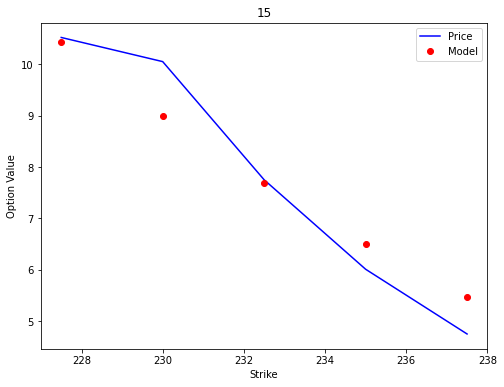

In [26]:
generate_plot(opt, options);